### Steps

This colab demonstrates how to
- Make predictions with Enformer and reproduce Fig. 1d
- Compute contribution scores and reproduce parts of Fig. 2a
- Predict the effect of a genetic variant and reproduce parts of Fig. 3g
- Score multiple variants in a VCF 

## Setup

**Start the colab kernel with GPU**: Runtime -> Change runtime type -> GPU

In [1]:
import tensorflow as tf

In [2]:
%pip install kipoiseq==0.5.2
# You can ignore the pyYAML error

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [3]:
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
#transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'saved_models/enformer_komlos_final'
fasta_file = 'hg38.fa.gz'
clinvar_vcf = 'clinvar.vcf'

In [ ]:
import urllib.request
import os
transform_url = 'https://storage.googleapis.com/dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
transform_path = 'enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'

if not os.path.exists(transform_path):
    print("Downloading transform file...")
    urllib.request.urlretrieve(transform_url, transform_path)
    print("Download complete!")
else:
    print("Transform file already exists!")

Download complete!


In [5]:
# Download targets from Basenji2 dataset 
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets.head(3)

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion


### Download files

Download and index the reference genome fasta file

Credit to Genome Reference Consortium: https://www.ncbi.nlm.nih.gov/grc

Schneider et al 2017 http://dx.doi.org/10.1101/gr.213611.116: Evaluation of GRCh38 and de novo haploid genome assemblies demonstrates the enduring quality of the reference assembly

In [6]:
# !mkdir -p /root/data
# !wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gbzip -c > {fasta_file}
# pyfaidx.Faidx(fasta_file)
# !ls /root/data

Download the clinvar file. Reference:

Landrum MJ, Lee JM, Benson M, Brown GR, Chao C, Chitipiralla S, Gu B, Hart J, Hoffman D, Jang W, Karapetyan K, Katz K, Liu C, Maddipatla Z, Malheiro A, McDaniel K, Ovetsky M, Riley G, Zhou G, Holmes JB, Kattman BL, Maglott DR. ClinVar: improving access to variant interpretations and supporting evidence. Nucleic Acids Res . 2018 Jan 4. PubMed PMID: 29165669 .


In [7]:
# !wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz -O /root/data/clinvar.vcf.gz

In [ ]:

class Enformer:
    def __init__(self, model_path):
        # Load SavedModel instead of Hub model
        self._model = tf.saved_model.load(model_path)

    def predict_on_batch(self, inputs):
        # Convert inputs to tensor if needed
        if not isinstance(inputs, tf.Tensor):
            inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        
        # Use the signature
        predictions = self._model.signatures['serving_default'](sequence=inputs)
        return {k: v.numpy() for k, v in predictions.items()}

    @tf.function
    def contribution_input_grad(self, input_sequence, target_mask, output_head='human'):
        input_sequence = input_sequence[tf.newaxis]
        target_mask_mass = tf.reduce_sum(target_mask)
        
        with tf.GradientTape() as tape:
            tape.watch(input_sequence)
            prediction = tf.reduce_sum(
                target_mask[tf.newaxis] *
                self.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

        input_grad = tape.gradient(prediction, input_sequence) * input_sequence
        input_grad = tf.squeeze(input_grad, axis=0)
        return tf.reduce_sum(input_grad, axis=-1)

### Code (double click on the title to show the code)

In [61]:
# @title `Enformer`, `EnformerScoreVariantsNormalized`, `EnformerScoreVariantsPCANormalized`,
#SEQUENCE_LENGTH = 393216
SEQUENCE_LENGTH = 196608

# class Enformer:

#   def __init__(self, tfhub_url):
#     self._model = hub.load(tfhub_url).model

#   def predict_on_batch(self, inputs):
#     predictions = self._model.predict_on_batch(inputs)
#     return {k: v.numpy() for k, v in predictions.items()}

#   @tf.function
#   def contribution_input_grad(self, input_sequence,
#                               target_mask, output_head='human'):
#     input_sequence = input_sequence[tf.newaxis]

#     target_mask_mass = tf.reduce_sum(target_mask)
#     with tf.GradientTape() as tape:
#       tape.watch(input_sequence)
#       prediction = tf.reduce_sum(
#           target_mask[tf.newaxis] *
#           self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

#     input_grad = tape.gradient(prediction, input_sequence) * input_sequence
#     input_grad = tf.squeeze(input_grad, axis=0)
#     return tf.reduce_sum(input_grad, axis=-1)


# class EnformerScoreVariantsRaw:

#   def __init__(self, tfhub_url, organism='human'):
#     self._model = Enformer(tfhub_url)
#     self._organism = organism
  
#   def predict_on_batch(self, inputs):
#     ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
#     alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

#     return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)


class EnformerScoreVariantsRaw:
    def __init__(self, model_wrapper, organism='human'):
        self._model = model_wrapper
        self._organism = organism
    
    def predict_on_batch(self, inputs):
        ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
        alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]
        # Use tf.reduce_mean instead of .mean()
        return tf.reduce_mean(alt_prediction, axis=1) - tf.reduce_mean(ref_prediction, axis=1)


class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)


class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features
    
  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]


# TODO(avsec): Add feature description: Either PCX, or full names.

In [ ]:
# @title `variant_centered_sequences`

class FastaStringExtractor:
    
    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()


def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)
    
  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)


def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)


def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}


def komlos_encode(sequence):
    """Convert one-hot encoded sequence to custom encoding:
    A → (+1, +1, −1)
    C → (−1, +1, +1)
    T → (+1, −1, +1)
    G → (−1, −1, −1)
    """
    
    one_hot = one_hot_encode(sequence)  # This gives us [A, C, G, T] format
    
    
    a_pos = one_hot[:, 0]  # A positions
    c_pos = one_hot[:, 1]  # C positions  
    t_pos = one_hot[:, 2]  # T positions
    g_pos = one_hot[:, 3]  # G positions
    
    dim1 = (a_pos + t_pos) * 1.0 + (c_pos + g_pos) * -1.0  # +1 for A/T, -1 for C/G
    dim2 = (a_pos + c_pos) * 1.0 + (t_pos + g_pos) * -1.0  # +1 for A/C, -1 for T/G
    dim3 = (a_pos + g_pos) * -1.0 + (t_pos + c_pos) * 1.0  # -1 for A/G, +1 for T/C
    
    encoded = np.stack([dim1, dim2, dim3], axis=-1)
    return encoded

In [10]:
# @title `plot_tracks`

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

## Make predictions for a genetic sequenece

In [11]:
# model = tf.saved_model.load(model_path)

# fasta_file = 'hg38.fa'
# fasta_extractor = FastaStringExtractor(fasta_file)

# Replace the model loading section with this:

# Import the original Enformer class


In [ ]:

import enformer_with_rope2 as enformer
import os

import sonnet as snt


model = enformer.Enformer(channels=1536//4,  # 384 channels
                          num_heads=2,
                          num_transformer_layers=11,
                          pooling_type='max')


optimizer = snt.optimizers.Adam(learning_rate=0.0005)


checkpoint_dir = 'checkpoints/enformer_komlos_final'
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

print("Model loaded from checkpoint successfully!")


def komlos_encode(sequence):
    """Convert one-hot encoded sequence to custom encoding"""
    one_hot = one_hot_encode(sequence)
    a_pos = one_hot[:, 0]
    c_pos = one_hot[:, 1] 
    t_pos = one_hot[:, 2]
    g_pos = one_hot[:, 3]
    
    dim1 = (a_pos + t_pos) * 1.0 + (c_pos + g_pos) * -1.0
    dim2 = (a_pos + c_pos) * 1.0 + (t_pos + g_pos) * -1.0
    dim3 = (a_pos + g_pos) * -1.0 + (t_pos + c_pos) * 1.0
    
    encoded = np.stack([dim1, dim2, dim3], axis=-1)
    return encoded

fasta_file = 'hg38.fa'
fasta_extractor = FastaStringExtractor(fasta_file)

Model loaded from checkpoint successfully!


In [ ]:
# # @title Make predictions for an genomic example interval
target_interval = kipoiseq.Interval('chr11', 35_082_742, 35_197_430)  # @param

sequence_one_hot = komlos_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]



# sequence_one_hot = komlos_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))

# # Fix: Convert to tensor and use keyword argument
# sequence_tensor = tf.convert_to_tensor(sequence_one_hot[np.newaxis], dtype=tf.float32)
# predictions = model.signatures['serving_default'](sequence=sequence_tensor)

# # Extract the human predictions
# human_predictions = predictions['human'][0]

In [14]:
predictions

<tf.Tensor: shape=(896, 5313), dtype=float32, numpy=
array([[0.50179374, 0.56817216, 0.9063445 , ..., 0.4041534 , 0.9751478 ,
        0.627782  ],
       [0.51014715, 0.60299695, 0.7115426 , ..., 0.75447947, 0.75849825,
        0.7382504 ],
       [0.6857639 , 0.49065775, 0.777327  , ..., 0.5311938 , 0.7300115 ,
        0.5770989 ],
       ...,
       [0.7653007 , 0.32560351, 0.86296725, ..., 0.6419141 , 0.67759955,
        0.6765983 ],
       [0.5972587 , 0.5702338 , 0.6459604 , ..., 0.51106834, 0.64437366,
        0.584463  ],
       [0.58904797, 0.67122245, 0.68766636, ..., 0.65708447, 0.7934811 ,
        1.1056201 ]], dtype=float32)>

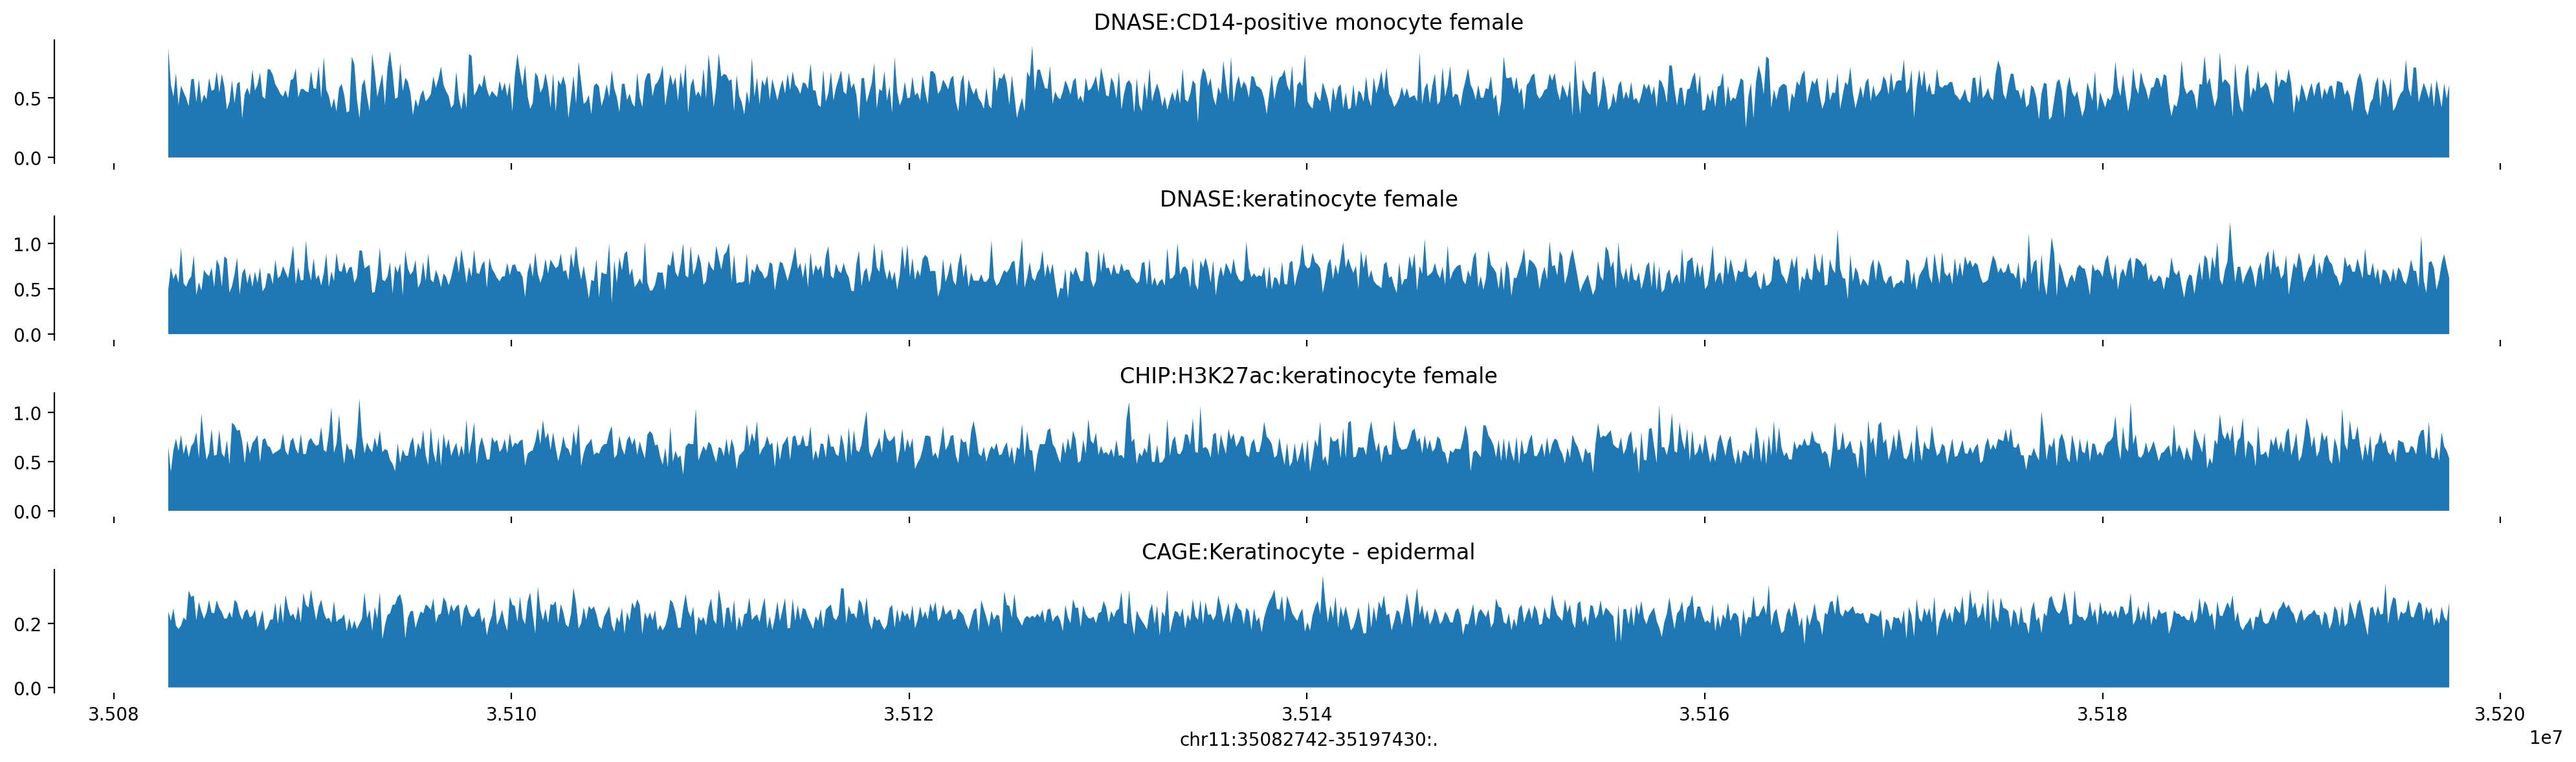

In [15]:
# @title Plot tracks

# tracks = {'DNASE:CD14-positive monocyte female': predictions[:, 41],
#           'DNASE:keratinocyte female': predictions[:, 42],
#           'CHIP:H3K27ac:keratinocyte female': predictions[:, 706],
#           'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions[:, 4799])}
# plot_tracks(tracks, target_interval)
# Convert TensorFlow tensor to NumPy array


predictions_np = predictions.numpy()

# Create tracks
tracks = {'DNASE:CD14-positive monocyte female': predictions_np[:, 41],
          'DNASE:keratinocyte female': predictions_np[:, 42],
          'CHIP:H3K27ac:keratinocyte female': predictions_np[:, 706],
          'CAGE:Keratinocyte - epidermal': np.log10(1 + predictions_np[:, 4799])}
plot_tracks(tracks, target_interval)

## Contribution scores example

In [18]:
# # # @title Compute contribution scores
# # target_interval = kipoiseq.Interval('chr12', 54_223_589, 54_338_277)  # @param

# # sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
# # predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

# # target_mask = np.zeros_like(predictions)
# # for idx in [447, 448, 449]:
# #   target_mask[idx, 4828] = 1
# #   target_mask[idx, 5111] = 1
# # # This will take some time since tf.function needs to get compiled.





# sequence_one_hot = komlos_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))

# # Convert to tensor and make prediction using SavedModel signature
# sequence_tensor = tf.convert_to_tensor(sequence_one_hot[np.newaxis], dtype=tf.float32)
# #predictions = model.signatures['serving_default'](sequence=sequence_tensor)
# predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

# # Extract human predictions as NumPy array
# human_predictions = predictions['human'][0].numpy()

# # Create target mask
# target_mask = np.zeros_like(human_predictions)
# for idx in [447, 448, 449]:
#     target_mask[idx, 4828] = 1
#     target_mask[idx, 5111] = 1


# contribution_scores = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask).numpy()
# pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()[1088:-1088]



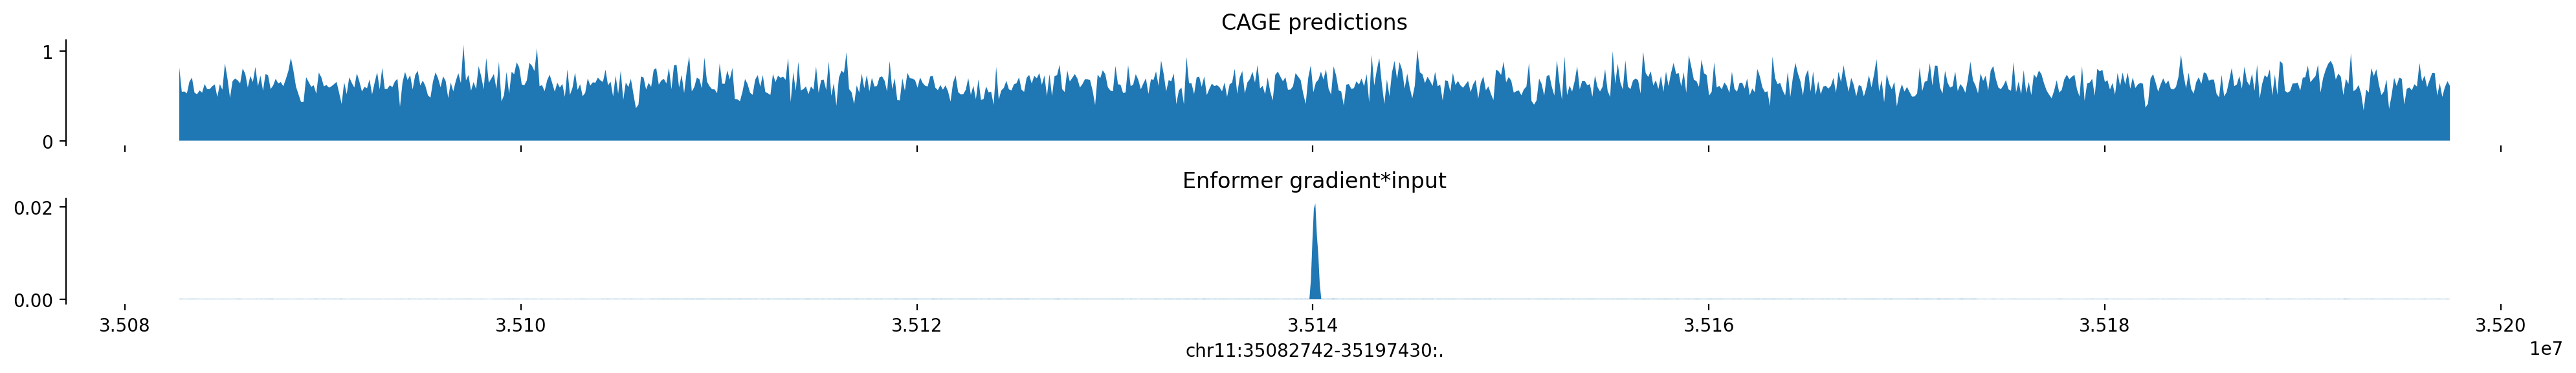

In [ ]:

SEQUENCE_LENGTH = 196608

target_interval = kipoiseq.Interval('chr11', 35_082_742, 35_197_430)
sequence_one_hot = komlos_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))


predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]


human_predictions = predictions.numpy()


target_mask = np.zeros_like(human_predictions)
for idx in [447, 448, 449]:
    target_mask[idx, 4828] = 1
    target_mask[idx, 5111] = 1

contribution_scores = model.contribution_input_grad(sequence_one_hot.astype(np.float32), target_mask).numpy()
#pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()[1088:-1088]
pooled_contribution_scores = tf.nn.avg_pool1d(np.abs(contribution_scores)[np.newaxis, :, np.newaxis], 128, 128, 'VALID')[0, :, 0].numpy()

# Plot tracks
tracks = {'CAGE predictions': human_predictions[:, 4828],
          'Enformer gradient*input': np.minimum(pooled_contribution_scores, 0.03)}
plot_tracks(tracks, target_interval)

In [25]:
len(pooled_contribution_scores)

1536

In [27]:
# tracks = {'CAGE predictions': predictions[:, 4828],
#           'Enformer gradient*input': np.minimum(pooled_contribution_scores, 0.03)}
# plot_tracks(tracks, target_interval)

## Variant scoring example

In [ ]:
# # @title Score the variant
# variant = kipoiseq.Variant('chr16', 57025062, 'C', 'T', id='rs11644125')  # @param


# interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
# seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
# center = interval.center() - interval.start

# reference = seq_extractor.extract(interval, [], anchor=center)
# alternate = seq_extractor.extract(interval, [variant], anchor=center)


# reference_prediction = model.predict_on_batch(one_hot_encode(reference)[np.newaxis])['human'][0]
# alternate_prediction = model.predict_on_batch(one_hot_encode(alternate)[np.newaxis])['human'][0]

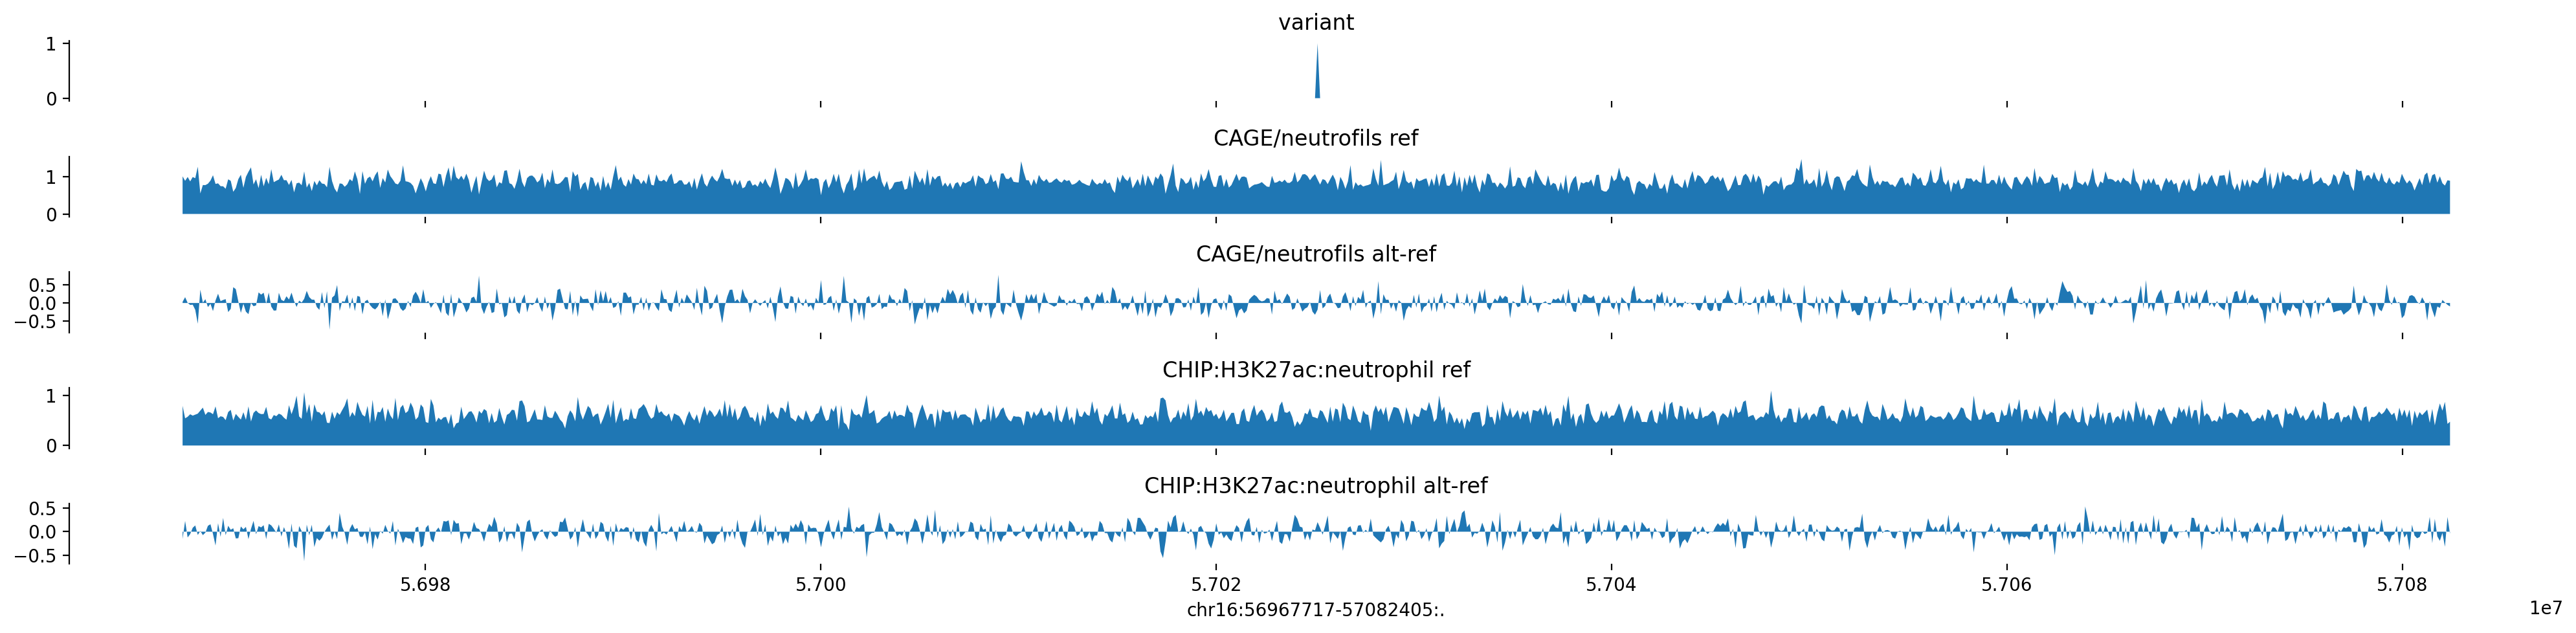

In [ ]:
# @title Score the variant
variant = kipoiseq.Variant('chr16', 57025062, 'C', 'T', id='rs11644125')  # @param

interval = kipoiseq.Interval(variant.chrom, variant.start, variant.start).resize(SEQUENCE_LENGTH)
seq_extractor = kipoiseq.extractors.VariantSeqExtractor(reference_sequence=fasta_extractor)
center = interval.center() - interval.start

reference = seq_extractor.extract(interval, [], anchor=center)
alternate = seq_extractor.extract(interval, [variant], anchor=center)


reference_prediction = model.predict_on_batch(komlos_encode(reference)[np.newaxis])['human'][0]
alternate_prediction = model.predict_on_batch(komlos_encode(alternate)[np.newaxis])['human'][0]


reference_prediction_np = reference_prediction.numpy()
alternate_prediction_np = alternate_prediction.numpy()


variant_track = np.zeros_like(reference_prediction_np[:, 0], dtype=bool)
variant_track[variant_track.shape[0] // 2] = True
tracks = {'variant': variant_track,
          'CAGE/neutrofils ref': reference_prediction_np[:, 4767],
          'CAGE/neutrofils alt-ref': alternate_prediction_np[:, 4767] - reference_prediction_np[:, 4767],
          'CHIP:H3K27ac:neutrophil ref': reference_prediction_np[:, 2280],
          'CHIP:H3K27ac:neutrophil alt-ref': alternate_prediction_np[:, 2280] - reference_prediction_np[:, 2280],
          }

plot_tracks(tracks, interval.resize(reference_prediction_np.shape[0] * 128), height=1)

In [ ]:
# # @title Visualize some tracks
# variant_track = np.zeros_like(reference_prediction[:, 0], dtype=bool)
# variant_track[variant_track.shape[0] // 2] = True
# tracks = {'variant': variant_track,
#           'CAGE/neutrofils ref': reference_prediction[:, 4767],
#           'CAGE/neutrofils alt-ref': alternate_prediction[:, 4767] - reference_prediction[:, 4767],
#           'CHIP:H3K27ac:neutrophil ref': reference_prediction[:, 2280],
#           'CHIP:H3K27ac:neutrophil alt-ref': alternate_prediction[:, 2280] - reference_prediction[:, 2280],
#           }

# plot_tracks(tracks, interval.resize(reference_prediction.shape[0] * 128), height=1)

## Score variants in a VCF file

### Report top 20 PCs

In [48]:
# enformer_score_variants = EnformerScoreVariantsPCANormalized(model_path, transform_path, num_top_features=20)

In [ ]:
def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
    seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
        reference_sequence=FastaStringExtractor(fasta_file))

    for variant in variant_generator(vcf_file, gzipped=gzipped):
        interval = Interval(chr_prefix + variant.chrom,
                            variant.pos, variant.pos)
        interval = interval.resize(sequence_length)
        center = interval.center() - interval.start

        reference = seq_extractor.extract(interval, [], anchor=center)
        alternate = seq_extractor.extract(interval, [variant], anchor=center)

       
        yield {'inputs': {'ref': komlos_encode(reference),
                          'alt': komlos_encode(alternate)},
               'metadata': {'chrom': chr_prefix + variant.chrom,
                            'pos': variant.pos,
                            'id': variant.id,
                            'ref': variant.ref,
                            'alt': variant.alt}}

In [ ]:

# class Enformer:
#     def __init__(self, model):
#         self._model = model

#     def predict_on_batch(self, inputs):
#         if not isinstance(inputs, tf.Tensor):
#             inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
#         predictions = self._model.predict_on_batch(inputs)
#         return {k: v.numpy() for k, v in predictions.items()}


# enformer_wrapper = Enformer(model)


# class EnformerScoreVariantsRaw:
#     def __init__(self, model_wrapper, organism='human'):
#         self._model = model_wrapper
#         self._organism = organism
    
#     def predict_on_batch(self, inputs):
#         ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
#         alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]
#         return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)

# class EnformerScoreVariantsPCANormalized:
#     def __init__(self, model_wrapper, transform_pkl_path, organism='human', num_top_features=500):
#         self._model = EnformerScoreVariantsRaw(model_wrapper, organism)
#         with open(transform_pkl_path, 'rb') as f:
#             self._transform = joblib.load(f)
#         self._num_top_features = num_top_features
    
#     def predict_on_batch(self, inputs):
#         scores = self._model.predict_on_batch(inputs)
#         return self._transform.transform(scores)[:, :self._num_top_features]


# enformer_score_variants = EnformerScoreVariantsPCANormalized(enformer_wrapper, transform_path, num_top_features=20)

In [ ]:

class Enformer:
    def __init__(self, model):
        self._model = model

    def predict_on_batch(self, inputs):
        if not isinstance(inputs, tf.Tensor):
            inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        predictions = self._model.predict_on_batch(inputs)
        return {k: v.numpy() for k, v in predictions.items()}


enformer_wrapper = Enformer(model)


class EnformerScoreVariantsRaw:
    def __init__(self, model_wrapper, organism='human'):
        self._model = model_wrapper
        self._organism = organism
    
    def predict_on_batch(self, inputs):
        ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
        alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]
        # Use tf.reduce_mean instead of .mean()
        return tf.reduce_mean(alt_prediction, axis=1) - tf.reduce_mean(ref_prediction, axis=1)

class EnformerScoreVariantsNormalized:
    def __init__(self, model_wrapper, transform_pkl_path, organism='human'):
        self._model = EnformerScoreVariantsRaw(model_wrapper, organism)
        with open(transform_pkl_path, 'rb') as f:
            self._transform = joblib.load(f)
    
    def predict_on_batch(self, inputs):
        scores = self._model.predict_on_batch(inputs)
        return self._transform.transform(scores)


enformer_score_variants_all = EnformerScoreVariantsNormalized(enformer_wrapper, transform_path)

In [58]:
# Score the first 5 variants from ClinVar
# Lower-dimensional scores (20 PCs)
fasta_file = 'hg38.fa'  # Use uncompressed version
fasta_extractor = FastaStringExtractor(fasta_file)

it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=False, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'PC{i}': score for i, score in enumerate(variant_scores)}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,PC0,PC1,PC2,PC3,PC4,...,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,chr1,66926,3385321,AG,A,9.334575,19.422888,-5.121991,-23.496672,37.546158,...,-15.542336,-5.958402,-2.966349,-16.205658,-31.493626,-13.632426,-12.773229,-13.134648,-14.987567,9.223237
1,chr1,69134,2205837,A,G,-1.962474,-6.588768,18.757439,15.522781,-18.359558,...,-24.553371,-17.378462,20.024595,51.300163,20.080383,4.491814,-50.389248,68.842529,-28.908886,-39.225250
2,chr1,69314,3205580,T,G,-20.238779,2.333311,-22.981670,-27.309082,60.093349,...,-21.802380,10.850199,28.987463,26.307539,6.787726,64.660027,-8.748435,33.640408,-13.772110,12.445210
3,chr1,69423,3205581,G,A,-18.442930,-26.829895,5.945179,8.667594,-25.631891,...,19.079308,-1.466136,-10.435041,25.397110,30.234510,10.455691,9.780180,-23.343134,15.947225,-24.300951
4,chr1,69581,2252161,C,G,-6.509417,-13.324107,13.822755,14.833894,-38.663792,...,-9.170658,-15.983820,-24.624140,-35.901695,-12.845168,-42.928585,39.971302,20.398111,16.265835,2.619023


### Report all 5,313 features (z-score normalized)

In [59]:
enformer_score_variants_all = EnformerScoreVariantsNormalized(model, transform_path)

C:\Users\Maged\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Maged\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Maged\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 0.23.2 whe

In [66]:
# Score the first 5 variants from ClinVar
# All Scores
it = variant_centered_sequences(clinvar_vcf, sequence_length=SEQUENCE_LENGTH,
                                gzipped=False, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 5:
    break
  variant_scores = enformer_score_variants_all.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'{i}_{name[:20]}': score for i, (name, score) in enumerate(zip(df_targets.description, variant_scores))}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')
df = pd.DataFrame(example_list)
df

Done 0
Done 2
Done 4


,chrom,pos,id,ref,alt,0_DNASE:cerebellum mal,1_DNASE:frontal cortex,2_DNASE:chorion,3_DNASE:Ishikawa treat,4_DNASE:GM03348,...,490_DNASE:HK-2,491_DNASE:NCI-H460,492_DNASE:left lung male,493_DNASE:common myeloid,494_DNASE:stomach female,"495_DNASE:CD4-positive,",496_DNASE:kidney female,497_DNASE:skin fibroblas,498_DNASE:placenta femal,499_DNASE:brain male emb
0,chr1,66926,3385321,AG,A,3.722775,5.448913,2.489731,-12.279956,44.154586,...,40.875543,-38.776044,46.997479,-64.226703,25.905631,-61.962908,-179.186966,31.083669,-127.145503,84.765863
1,chr1,69134,2205837,A,G,8.665575,29.905680,-21.770799,-1.148900,-20.989087,...,96.958067,32.629123,150.181253,-46.456616,218.642630,82.560578,211.882243,-43.178982,-23.560264,26.175504
2,chr1,69314,3205580,T,G,17.460109,47.000389,-32.236440,-35.205374,2.085742,...,-107.292966,-131.574187,30.756271,11.021757,16.078695,-3.699905,33.579432,6.407644,4.368514,-120.085500
3,chr1,69423,3205581,G,A,-19.007018,-12.628685,25.514597,-30.300896,70.586992,...,-155.239061,-39.202606,106.624389,266.219131,80.166878,88.246456,-130.189636,-11.078661,-156.046451,-71.575724
4,chr1,69581,2252161,C,G,-23.023911,25.297205,-22.467199,-50.149362,18.372424,...,-19.363262,5.809361,88.146336,22.699849,118.226279,71.913543,-61.716273,35.422064,-157.247497,170.356016
